<a href="https://colab.research.google.com/github/saeu5407/img_multi_task/blob/main/code/multilable_cnn_fashion_mnist.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 작업 내용

1. train, valid 7:3으로 분리하여 작업
2. 데이터셋이 부족하여 회전 등 생성 작업을 진행하여 작업
3. 시간관계상 데이터사이즈, 모델링을 최소화하여 작업



In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import os
import shutil
import sys
import random
import tqdm
import glob
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential, load_model
from keras.layers import (Activation, Dropout, Flatten, Dense, GlobalMaxPooling2D,
                          BatchNormalization, Input, Conv2D, GlobalAveragePooling2D, Concatenate)
# from tensorflow.keras.applications import EfficientNetB0
import tensorflow as tf
from keras import metrics
from keras import backend as K
from keras.models import Model
from keras.preprocessing.image import ImageDataGenerator
from keras.utils import np_utils
from keras.preprocessing.image import array_to_img, img_to_array, load_img
from keras.layers import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from sklearn.metrics import accuracy_score
import warnings
warnings.filterwarnings('ignore')

In [3]:
# 데이터셋 경로
base_path = '/content/drive/MyDrive/Git/img_multi_task'
as_is_path = base_path + '/data/Fashion_MNIST_2/images'

# 라벨링 정보 데이터
label_df = pd.read_csv(base_path + '/data/Fashion_MNIST_2/labels.csv')

In [4]:
# MultiLabelBinarizer를 사용하여 라벨링
from sklearn.preprocessing import MultiLabelBinarizer

mlb = MultiLabelBinarizer()
labels = mlb.fit_transform(label_df.class_name.map(lambda x : x.lower().replace(" ","").split(',')))
print(mlb.classes_)
labels_name = mlb.classes_

# 라벨링된 데이터셋 경로 데이터프레임 생성
datapath_df = pd.DataFrame(labels, columns = labels_name)
datapath_df['path'] = as_is_path + '/' + label_df.file_name
datapath_df.head(5)

['ankleboot' 'bag' 'coat' 'dress' 'pullover' 'sandal' 'shirt' 'sneaker'
 't-shirt/top' 'trouser']


,ankleboot,bag,coat,dress,pullover,sandal,shirt,sneaker,t-shirt/top,trouser,path
0,0,1,0,0,0,0,0,0,1,1,/content/drive/MyDrive/Git/img_multi_task/data...
1,1,1,0,0,1,0,0,0,0,0,/content/drive/MyDrive/Git/img_multi_task/data...
2,0,0,1,0,0,0,1,0,1,1,/content/drive/MyDrive/Git/img_multi_task/data...
3,1,1,0,0,1,0,0,1,0,0,/content/drive/MyDrive/Git/img_multi_task/data...
4,0,1,0,1,0,0,0,0,1,0,/content/drive/MyDrive/Git/img_multi_task/data...


In [5]:
train_df = datapath_df.iloc[0:6000]
valid_df = datapath_df.iloc[6000:8000]
test_df = datapath_df.iloc[8000:10000]

In [6]:
# 전처리(train)
# 이미지 스케일링
trainDataGen = ImageDataGenerator(rescale=1./255, # 이미지 스케일링
                                 rotation_range = 30, # 임의로 이미지를 회전
                                 width_shift_range=0.1, # 임의로 이미지를 수평 이동
                                 height_shift_range=0.1, # 임의로 이미지를 수직 이동
                                 shear_range=0.2, # 임의로 이미지를 변형
                                 zoom_range=0.2, # 임의로 이미지를 확대/축소
                                 horizontal_flip=False, # 수평방향으로 뒤집기
                                 fill_mode='nearest' # 이미지 경계의 바깥 공간을 어떻게 채울지에 대한 파라미터
                                 )

testDataGen = ImageDataGenerator(rescale=1./255)

In [7]:
# Train Set
trainGenSet = testDataGen.flow_from_dataframe(
      train_df,
      x_col='path',
      y_col=labels_name,
      batch_size=32,
      seed=42,
      shuffle=True,
      target_size=(224,224),
      class_mode='raw')

# Valid Set
testGenSet = testDataGen.flow_from_dataframe(
      valid_df,
      x_col='path',
      y_col=labels_name,
      batch_size=32,
      seed=42,
      shuffle=True,
      target_size=(224,224),
      class_mode='raw')

# Test Set
finalGenSet = testDataGen.flow_from_dataframe(
      test_df,
      x_col='path',
      y_col=labels_name,
      batch_size=32,
      seed=42,
      shuffle=False,
      target_size=(224,224),
      class_mode='raw')

Found 6000 validated image filenames.
Found 2000 validated image filenames.
Found 2000 validated image filenames.


ankleboot                                                      0
bag                                                            0
coat                                                           1
dress                                                          0
pullover                                                       0
sandal                                                         1
shirt                                                          0
sneaker                                                        1
t-shirt/top                                                    0
trouser                                                        0
path           /content/drive/MyDrive/Git/img_multi_task/data...
Name: 8000, dtype: object


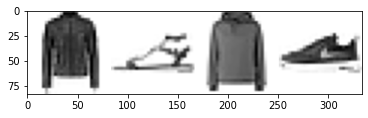

In [8]:
# 샘플 이미지
print(test_df.iloc[0])
a = plt.imread(test_df.path.iloc[0])
plt.imshow(a)

In [9]:
a.shape

(83, 334, 4)

In [ ]:
%cd drive/My\ Drive/Git/img_multi_task/code
from vgg16_adj import vgg16_adj

model = vgg16_adj(model_type = 'pooling',       # pooling 또는 flatten 형식 설정
                  loss='MAE',   # keras 기준, 필요한 loss function 설정
                  final_dense=len(labels_name), # 최종 결과 Dense 설정
                  final_activation='sigmoid',   # 마지막 Activation 설정
                  input_shape = (83, 334, 3))

# fig_generator
early_stopping = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=2000)
checkpoint = ModelCheckpoint(base_path + '/model/multilabel_model_fashion.h5', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

model.fit_generator(
    trainGenSet,
    steps_per_epoch=43,
    epochs=100,
    validation_data=testGenSet,
    validation_steps=10,
    callbacks=[early_stopping, checkpoint]
)

scores = model.evaluate_generator(testGenSet)
print(scores)

/content/drive/My Drive/Git/img_multi_task/code
Model: "VGG16_ADJ"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 83, 334, 64)       1792      
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 83, 334, 64)       36928     
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 41, 167, 64)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 41, 167, 128)      73856     
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 41, 167, 128)      147584    
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 20, 83, 128)       0         
_________________________________________________________________
conv2d_4 

In [ ]:
model_ = load_model(base_path + '/model/multilabel_model_fashion.h5')
pred = model_.predict_generator(finalGenSet, steps=2)
pred_df = pd.DataFrame(pred, columns = labels_name)
pred_df['path'] = valid_df['path'].iloc[0:64].reset_index(drop=True)
pred_df.head(5)

In [ ]:
import matplotlib.pyplot as plt
j = 23
a = plt.imread(pred_df['path'][j])
plt.imshow(a)
pred_df.iloc[j:j+1,:] * 100